In [1]:
# Importing Dependencies.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
##########################
import pandas as pd
import numpy as np
#########################
from scipy import stats
#########################
import cufflinks as cf
cf.go_offline()
#########################
import datetime as dt
from datetime import timedelta
##########################
import matplotlib.pyplot as plt
import pyfolio as pf
import empyrical as ep

In [ ]:
from tvDatafeed import TvDatafeed, Interval
##########################################
username = ''
password = ''
##########################################
tv = TvDatafeed(username, password)
# NIFTY INDEX.
Nifty_index_data = tv.get_hist(symbol='NIFTY',
                                    exchange='NSE',
                                    interval=Interval.in_3_minute,
                                    n_bars=20000)
Nifty_index_data = df = Nifty_index_data[['symbol','open','high','low','close','volume']]
df = df.drop(columns='volume',axis=1)
df = df.between_time('9:15', '15:00')

# Retrieve the stock data from Yahoo Finance
stock_data = df

ERROR:tvDatafeed.main:error while signin


In [ ]:
# Calculate the Parabolic SAR 
def calculate_parabolic_sar(high, low, acceleration=0.01, max_acceleration=0.13):
    sar = []
    long_position = True
    acceleration_factor = acceleration
    extreme_point = high[0]
    sar.append(low[0] - (high[0] - low[0]))
    for i in range(1, len(high)):
        if long_position:
            if low[i] > sar[i-1]:
                sar.append(sar[i-1] + acceleration_factor*(extreme_point - sar[i-1]))
                if high[i] > extreme_point:
                    extreme_point = high[i]
                    acceleration_factor = min(acceleration_factor + acceleration, max_acceleration)
            else:
                long_position = False
                sar.append(extreme_point)
                extreme_point = low[i]
                acceleration_factor = acceleration
        else:
            if high[i] < sar[i-1]:
                sar.append(sar[i-1] + acceleration_factor*(extreme_point - sar[i-1]))
                if low[i] < extreme_point:
                    extreme_point = low[i]
                    acceleration_factor = min(acceleration_factor + acceleration, max_acceleration)
            else:
                long_position = True
                sar.append(extreme_point)
                extreme_point = high[i]
                acceleration_factor = acceleration
    return sar

In [ ]:
# Calculate the Average True Range (ATR) 
def calculate_atr(high, low, close, period=2):
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1, skipna=False)
    atr = true_range.rolling(window=period).mean()
    return atr

In [ ]:
# Define the strategy
def strategy(df):
    sar = calculate_parabolic_sar(df['high'], df['low'])
    atr = calculate_atr(df['high'], df['low'], df['close'])

    df['Signal'] = np.where(df['close'] > sar, 1, -1)
    #df['Signal'] = df['Signal'].where(df['Signal'].diff().fillna(0).ne(0), np.nan)

    for i in range(len(df)):
        if df.index[i].strftime('%H:%M:%S') == '09:15:00':df['Signal'][i] = 0
        #elif df.index[i].strftime('%H:%M:%S') == '14:45:00':df['Signal'][i] = 0


    df['ATR'] = atr   
    df['Stop Loss'] = df['Signal'] * (df['close'] - atr)
    df['Return'] = df['close'].pct_change() * df['Signal'].shift(1)
    return df

<Axes: xlabel='datetime'>

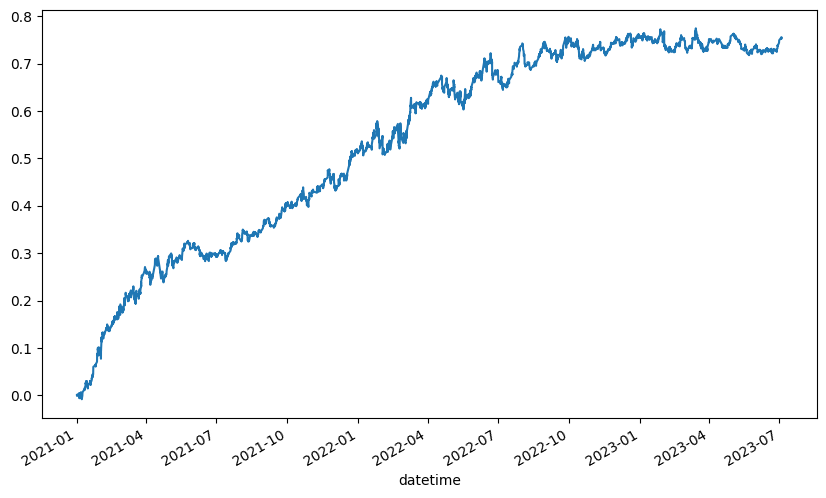

In [ ]:
# Backtest the strategy
backtest_data = strategy(stock_data)
backtest_data['Cumulative Return'] = (backtest_data['Return']).cumsum()
backtest_data['Cumulative Return'].plot(figsize=(10,6))

Start: 
2021-01-01 09:15:00 
End: 
2023-07-03 14:45:00
------------------------
Sortino Ratio: 0.93
Calmar Ratio: 0.33
Omega Ratio: 1.14
Tail Ratio: 1.08
------------------------------
The Annualised Sharpe Ratio is 0.62
Gains in Points: 12279.20
------------------------------
------------------------
Strategy Return: 75.47 %
The Max Drawdown: -7.52 %
Stability of Time Series : 0.89


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.52,2022-06-21,2022-07-07,2022-07-29,28
1,7.05,2022-04-18,2022-05-17,2022-06-03,34
2,6.94,2022-01-25,2022-02-04,2022-03-07,29
3,5.58,2023-03-14,2023-05-22,NaT,NaN
4,5.48,2022-08-01,2022-08-12,2022-08-29,20


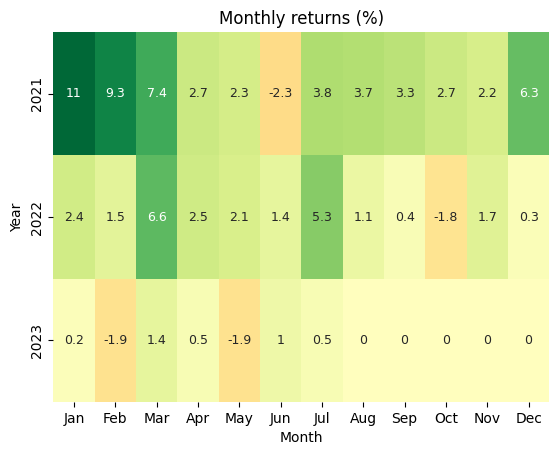

In [ ]:
def metrics():
# Importing Required Dependencies.
    import numpy as np
    import pandas as pd
    import empyrical as ep
    import pyfolio as pf


# This code calculate the gains in points based on a signal column 
    j = df.Signal  # forward-fill missing values in df.position
    e = df.close

    result = []
    for i in range(len(j)):
        if i == len(j)-1 or pd.isna(j[i]) or pd.isna(j[i+1]):
            result.append(0)  # if there's a missing value or last row, append 0
        elif j[i] == -1:
            result.append(e[i] - e[i+1])
        elif j[i] == 1:
            result.append(e[i+1] - e[i])
        else:
            result.append(0)

    total = sum(result)

# Calculate the annualised Sharpe ratio
    sharpe = np.sqrt(252) * \
    df.Return.mean() / df.Return.std()
# Calculating Max Drawdown.
    max_dd= ep.max_drawdown(df.Return)
# Calculating Stablity of Time Series of Returns.
    stablity = ep.stability_of_timeseries(df.Return)
# Calculating Sortino Ratio
    Sortino = ep.sortino_ratio(df.Return)
# Calculating Calmar ratio
    calmar_ratio = ep.calmar_ratio(df.Return)
# Calculating Omega ratio
    omega_ratio = ep.omega_ratio(df.Return, risk_free=0)
# Print start and end date of returns series
    print(f'Start: \n{df.index[0]} \nEnd: \n{df.index[-1]}')
    print('------------------------')
# Print various performance metrics
    print(f'Sortino Ratio: {(Sortino):.2f}') 
    print(f'Calmar Ratio: {calmar_ratio:.2f}')
    print(f'Omega Ratio: {omega_ratio:.2f}')
    print('Tail Ratio:',ep.tail_ratio(df['Return']).round(2))
    print('------------------------------')
    print("The Annualised Sharpe Ratio is %.2f" % sharpe)
    print(f'Gains in Points: {total:.2f}')
    print('------------------------------')
    # print(f'Total Signal Counts:\n{df.Signal.value_counts().to_string()}')
    print('------------------------')
    print(f'Strategy Return: {((df.Return.cumsum()[-1]*100)) :.2f} %') 
    print(f'The Max Drawdown: {(max_dd*100):.2f} %') #times 100
    print(f'Stability of Time Series : {stablity:.2f}')
# Plot worst drawdown periods and monthly returns heatmap
    pf.show_worst_drawdown_periods(df['Return'])
    pf.plot_monthly_returns_heatmap(df['Return'])
metrics()

In [ ]:
df.head(50)

,symbol,open,high,low,close,Signal,ATR,Stop Loss,Return,Cumulative Return
datetime,,,,,,,,,,
2021-01-01 09:15:00,NSE:NIFTY,13997.90,14028.90,13991.35,14023.95,0,NaN,NaN,NaN,NaN
2021-01-01 09:45:00,NSE:NIFTY,14025.05,14033.85,14016.30,14025.25,1,NaN,NaN,0.000000,0.000000
2021-01-01 10:15:00,NSE:NIFTY,14024.60,14036.45,14017.60,14028.90,1,18.200,14010.700,0.000260,0.000260
2021-01-01 10:45:00,NSE:NIFTY,14028.35,14037.25,14023.60,14029.35,1,16.250,14013.100,0.000032,0.000292
2021-01-01 11:15:00,NSE:NIFTY,14028.90,14034.25,14018.60,14019.55,1,14.650,14004.900,-0.000699,-0.000406
2021-01-01 11:45:00,NSE:NIFTY,14019.00,14025.95,14004.95,14023.05,1,18.325,14004.725,0.000250,-0.000157
2021-01-01 12:15:00,NSE:NIFTY,14022.70,14039.05,14015.95,14038.00,1,22.050,14015.950,0.001066,0.000910
2021-01-01 12:45:00,NSE:NIFTY,14037.70,14040.25,14027.20,14031.60,1,18.075,14013.525,-0.000456,0.000454
2021-01-01 13:15:00,NSE:NIFTY,14030.35,14039.30,14017.80,14025.80,1,17.275,14008.525,-0.000413,0.000040
